In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from matplotlib import rcParams

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Plot tree containing only two covariates
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clfTree1.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1599, 12)


(array([ 10.,   0.,  53.,   0., 681.,   0., 638.,   0., 199.,  18.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

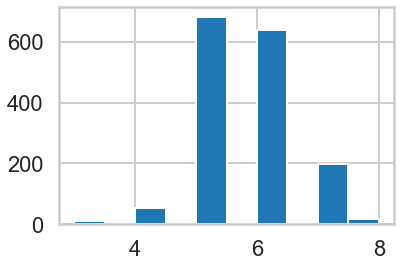

In [4]:
print (df.shape)

plt.hist(df.quality)

In [5]:
Y = df['quality'].values
df_tmp = df.drop('quality',1)
Y = np.array([1 if y>=7 else 0 for y in Y])
X = df_tmp.as_matrix()

df['target'] = (df['quality'].values >=7)*1

c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [6]:
Xnames = list(df.columns.values[1:11])

In [7]:
np.mean(df['target'])

0.1357098186366479

In [8]:
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [9]:
print ("% Good wines in Training:", np.mean(df.target[mask]))
print ("% Good wines in Testing:", np.mean(df.target[~mask]))

% Good wines in Training: 0.12930135557872785
% Good wines in Testing: 0.1453125


In [10]:
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 7, 'min_samples_leaf': 3} 0.3417638322747812 {'mean_fit_time': array([0.00075336, 0.00067983, 0.00172   , 0.00042791, 0.00112553,
       0.00165758, 0.00106916, 0.00172219, 0.00105357, 0.00070724,
       0.00090227, 0.00086799, 0.00131264, 0.00170584, 0.00218205,
       0.00186868, 0.00203834, 0.00039873, 0.00120144, 0.00092239,
       0.        , 0.00142126, 0.00126786, 0.00242071, 0.00065761,
       0.0007978 , 0.00161843, 0.00500612, 0.00143485, 0.00159698,
       0.00016832, 0.00259924, 0.0010314 , 0.00247927, 0.00019937,
       0.00100889, 0.00183825, 0.00183043, 0.00079899, 0.00312452,
       0.0016263 , 0.00160255]), 'std_fit_time': array([0.00067112, 0.00041022, 0.00088645, 0.00052756, 0.00122467,
       0.00120861, 0.00014169, 0.00211535, 0.00116736, 0.00061016,
       0.00080093, 0.00086295, 0.0007593 , 0.00134596, 0.00191358,
       0.00191991, 0.00165913, 0.00048834, 0.00147454, 0.00140054,
       0.        , 0.00146414, 0.00160227, 0.00197682,

c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


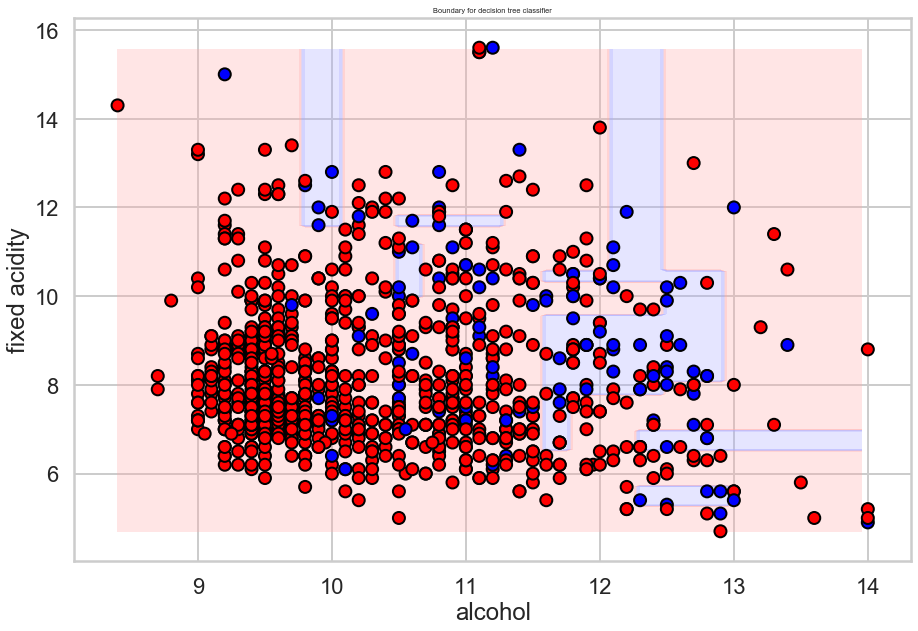

In [11]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_test = False)

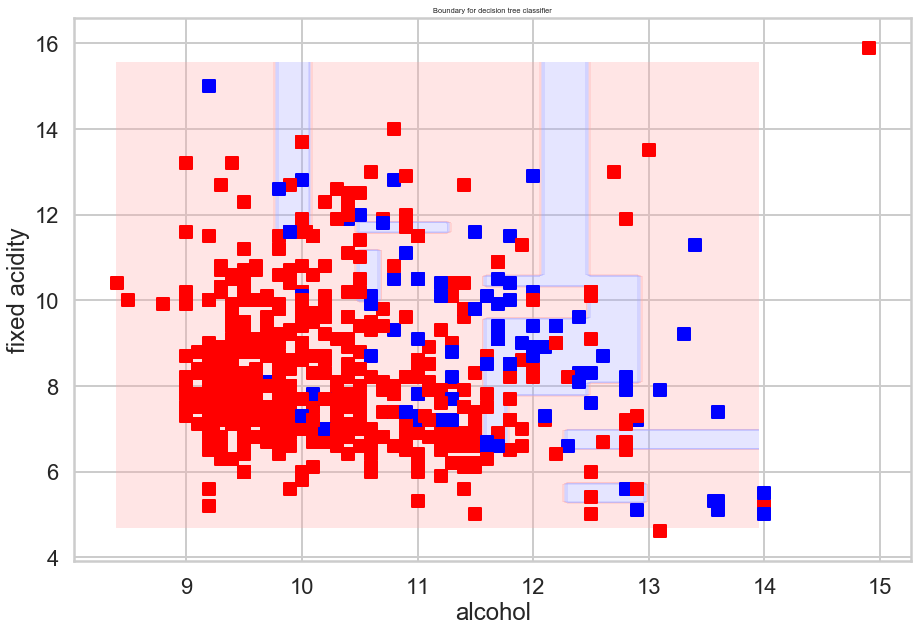

In [12]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = False)

using mask
BEST {'max_depth': None, 'min_samples_leaf': 6} 0.32656805352284185 {'mean_fit_time': array([0.00182123, 0.00080624, 0.00196505]), 'std_fit_time': array([0.00048574, 0.00161247, 0.00204554]), 'mean_score_time': array([0.00129042, 0.00283895, 0.00179701]), 'std_score_time': array([0.00086105, 0.0020458 , 0.00183071]), 'param_max_depth': masked_array(data=[None, None, None],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[4, 5, 6],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': None, 'min_samples_leaf': 4}, {'max_depth': None, 'min_samples_leaf': 5}, {'max_depth': None, 'min_samples_leaf': 6}], 'split0_test_score': array([0.25      , 0.24242424, 0.29411765]), 'split1_test_score': array([0.23076923, 0.28070175, 0.37209302]), 'split2_test_score': array([0.40909091, 0.40909091, 0.35897436]), 'split3_test_score': array([0.2909

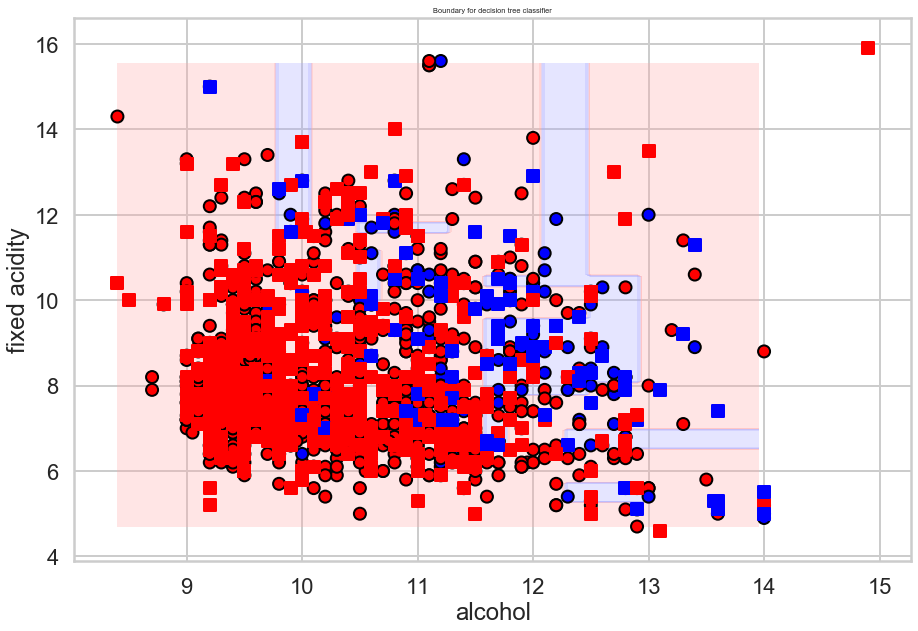

In [13]:
from sklearn import tree
clfTree_temp = tree.DecisionTreeClassifier()

parameters = {"max_depth": [None], 'min_samples_leaf': [4, 5, 6]}
clfTree_temp, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree_temp, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree_temp, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = True)

In [14]:
clfTree2 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, df, 
                                                     Xnames,'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 6, 'min_samples_leaf': 3} 0.41154826182403664 {'mean_fit_time': array([0.0008719 , 0.00118122, 0.00235643, 0.00253582, 0.00098004,
       0.00181017, 0.00119367, 0.00160441, 0.00152431, 0.00177717,
       0.00160294, 0.00210404, 0.00306611, 0.00243449, 0.00177083,
       0.00271168, 0.00245943, 0.00294909, 0.00235305, 0.00301523,
       0.00400109, 0.00232515, 0.00331702, 0.00455303, 0.00248294,
       0.0039454 , 0.00326576, 0.00398388, 0.00400972, 0.00468931,
       0.00499921, 0.00495443, 0.00413947, 0.00478411, 0.0068759 ,
       0.00530057, 0.00543547, 0.0046339 , 0.00514493, 0.00356226,
       0.00732136, 0.00748415, 0.00612836, 0.00680285, 0.00479655,
       0.00514808, 0.00515985, 0.00449128, 0.00463271, 0.00502996,
       0.00407734, 0.005093  , 0.00708885, 0.00534749, 0.0065938 ,
       0.00426617, 0.00612001, 0.00645204, 0.00572371, 0.00493026,
       0.00741587, 0.00509949, 0.00741868, 0.00571651, 0.00522943,
       0.00650373, 0.00581188, 0.00

c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask
BEST {'n_estimators': 3} 0.3610898540046661 {'mean_fit_time': array([0.00446677, 0.00690255, 0.00939174, 0.01784062, 0.01574202,
       0.01837029, 0.02666192, 0.03147335, 0.02672176, 0.03263006,
       0.0314755 , 0.03127575, 0.039364  , 0.04097996, 0.04517784,
       0.0371069 , 0.04803386, 0.0534761 , 0.05727429]), 'std_fit_time': array([0.0031888 , 0.00212462, 0.00175722, 0.0068995 , 0.00467581,
       0.00465517, 0.00635717, 0.00268711, 0.00548553, 0.00549678,
       0.00592545, 0.00527445, 0.0088163 , 0.00187667, 0.00471659,
       0.00523541, 0.00430828, 0.00532411, 0.00502848]), 'mean_score_time': array([0.00340834, 0.00103278, 0.00100965, 0.00212374, 0.00496035,
       0.0044559 , 0.0016562 , 0.00407391, 0.0036869 , 0.0062644 ,
       0.00415077, 0.00341206, 0.00465727, 0.0055213 , 0.00294957,
       0.00366898, 0.00481658, 0.00707383, 0.00458126]), 'std_score_time': array([0.00196242, 0.00091259, 0.00111438, 0.00259739, 0.00408588,
       0.00389556, 0.00142425, 0.

c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


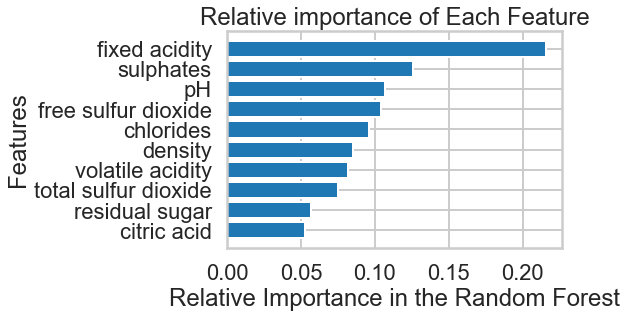

In [16]:
importance_list = clfForest.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [17]:
from sklearn.ensemble import AdaBoostClassifier

clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask
BEST {'n_estimators': 18} 0.4059113965574137 {'mean_fit_time': array([0.0328733 , 0.03932524, 0.03673611, 0.04389529, 0.0636972 ,
       0.06056342, 0.05489411, 0.05229959, 0.05510097, 0.05932331,
       0.06001153, 0.06928449, 0.06881528, 0.07471437, 0.07041063,
       0.07595897, 0.08122644, 0.08319588, 0.09131155, 0.09018364,
       0.09486108, 0.10049887, 0.10317197, 0.10516582, 0.10699315,
       0.1033886 , 0.1119801 , 0.10661478, 0.13020029, 0.14272423,
       0.13480935, 0.14100709, 0.13838663, 0.13937178, 0.12624173,
       0.13022337, 0.13607235, 0.14266362, 0.15367012, 0.15913415,
       0.14960384, 0.16811304, 0.17489753, 0.17669253, 0.18361735,
       0.17189631, 0.18495436, 0.1783546 , 0.19642892, 0.20357132]), 'std_fit_time': array([0.00270542, 0.00641203, 0.00229635, 0.00387001, 0.0073465 ,
       0.00641105, 0.00485997, 0.00131397, 0.00311192, 0.00792867,
       0.00584995, 0.00612073, 0.0066154 , 0.0077297 , 0.00920693,
       0.01057395, 0.01075934, 0.0095

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


c:\users\sravya bhaskara\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST {'max_depth': 4, 'n_estimators': 47} 0.33520483673401047 {'mean_fit_time': array([0.02873135, 0.03393822, 0.02676144, 0.03325429, 0.04294286,
       0.02807488, 0.04297552, 0.03557892, 0.02863917, 0.04355497,
       0.04163685, 0.0437778 , 0.04457726, 0.04858317, 0.04087939,
       0.04570422, 0.03892698, 0.0457952 , 0.04733133, 0.04552917,
       0.0454638 , 0.06683102, 0.05836411, 0.05162411, 0.05226016,
       0.05747108, 0.0576807 , 0.0634779 , 0.06431432, 0.06163034,
       0.04485497, 0.05074534, 0.04673033, 0.05518718, 0.04551902,
       0.04327726, 0.04797297, 0.05116692, 0.04831567, 0.05527024,
       0.05251088, 0.06007347, 0.06257482, 0.0608726 , 0.06252522,
       0.06008043, 0.06488876, 0.07272897, 0.0682487 , 0.06872978,
       0.06781101, 0.07127743, 0.07837873, 0.08233247, 0.07659721,
       0.09803786, 0.07505145, 0.07847533, 0.09073591, 0.09590292,
       0.06555095, 0.07919936, 0.07646813, 0.08256269, 0.10197501,
       0.08417454, 0.08381772, 0.08500104, 0.0869

In [19]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
# your code here
imp_cols = clfForest.feature_importances_.argsort()[::-1][0:2]

In [20]:
clfForest.feature_importances_

array([0.21601837, 0.08204826, 0.05255951, 0.05664583, 0.09585665,
       0.10411556, 0.07483722, 0.08537732, 0.10662793, 0.12591334])

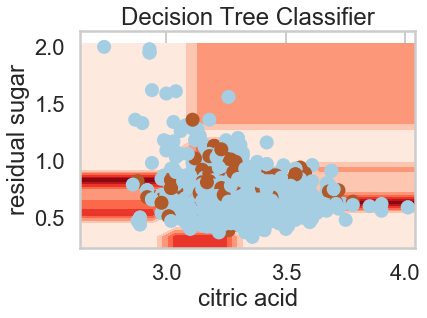

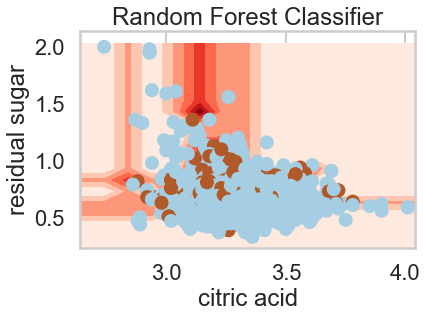

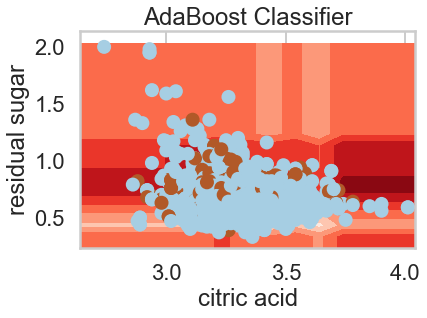

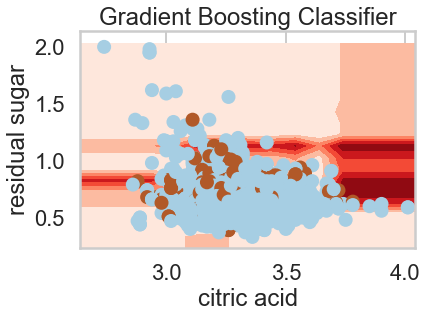

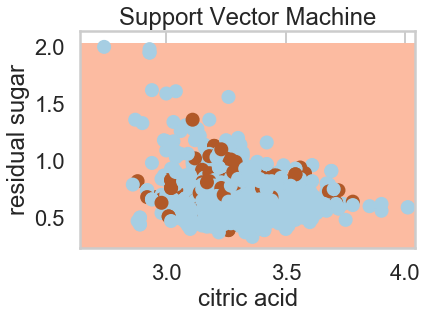

In [21]:
X_imp = df[['pH', 'sulphates']].values
Y = df.target.values

classifiers = [clfTree2,
               clfForest,
               clfAda,
               clfGB,
               sklearn.svm.SVC(C=100.0, gamma=1.0)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier', 
                  'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Support Vector Machine']
for c in range(5):
    plt.title(titleClassifer[c])
    plt.xlabel(name_list[0])
    plt.ylabel(name_list[1])
    plot_decision_surface(classifiers[c], X_imp, df.target.values)